# Musical Genre Recognition : Traditional Methods vs. Deep Learning


## Preparations on dataset

In this part, we are going to import important libraries and metadata files that were provided my the FMA database creators in order to filter the tracks according to their genres and apply different distributions to see how having common artists between datasets affect the accuracy

In [50]:
%matplotlib inline
import os; import shutil; import IPython.display as ipd; import numpy as np; import pandas as pd
import matplotlib.pyplot as plt; import seaborn as sns; import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm; import librosa; import librosa.display
import utils; import data_processing as datap; import feature_extraction as fext; import itertools as it
from scipy import stats

plt.rcParams['figure.figsize'] = (17, 10)

In [2]:
# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

print("shape of tracks.csv file is :", tracks.shape)
print("shape of genres.csv file is :", genres.shape)
print("shape of features.csv file is :", features.shape)
print("shape of echonest.csv file is :", echonest.shape)

shape of tracks.csv file is : (106574, 52)
shape of genres.csv file is : (163, 4)
shape of features.csv file is : (106574, 518)
shape of echonest.csv file is : (13129, 249)


### Distribution of tracks with artist order

Here we define the genres we are going to use in the database and we separate the tracks into training, validation, and test datasets by ordering artist name so that there will be nearly no common artists between datasets in order to detect only "genre" and not the "artist".

In [3]:
chosen_genres = ['Hip-Hop', 'Pop', 'Rock', 'Folk', 'Experimental', 'Electronic', 'Classical', 'Old-Time / Historic' ]
datap.data_reset(chosen_genres)
train_perc = 80
validation_perc = 10
test_perc = 10
datap.splitter(train_perc, validation_perc, test_perc ,chosen_genres, tracks)

Resetting training data of Hip-Hop genre
Resetting validation data of Hip-Hop genre
Resetting test data of Hip-Hop genre
Resetting training data of Pop genre
Resetting validation data of Pop genre
Resetting test data of Pop genre
Resetting training data of Rock genre
Resetting validation data of Rock genre
Resetting test data of Rock genre
Resetting training data of Folk genre
Resetting validation data of Folk genre
Resetting test data of Folk genre
Resetting training data of Experimental genre
Resetting validation data of Experimental genre
Resetting test data of Experimental genre
Resetting training data of Electronic genre
Resetting validation data of Electronic genre
Resetting test data of Electronic genre
Resetting training data of Classical genre
Resetting validation data of Classical genre
Resetting test data of Classical genre
Resetting training data of Old-Time / Historic genre
Resetting validation data of Old-Time / Historic genre
Resetting test data of Old-Time / Historic ge

As we separated tracks into their corresponding folders, we are going to extract track names now and put them in their corresponding list for training, validation, and test datasets.

In [4]:
train_tracks_list, valid_tracks_list, test_tracks_list = datap.track_extractor(chosen_genres)

400 training tracks from genre Hip-Hop extracted.
50 validation tracks from genre Hip-Hop extracted.
50 test tracks from genre Hip-Hop extracted.
400 training tracks from genre Pop extracted.
50 validation tracks from genre Pop extracted.
50 test tracks from genre Pop extracted.
400 training tracks from genre Rock extracted.
50 validation tracks from genre Rock extracted.
50 test tracks from genre Rock extracted.
400 training tracks from genre Folk extracted.
50 validation tracks from genre Folk extracted.
50 test tracks from genre Folk extracted.
400 training tracks from genre Experimental extracted.
50 validation tracks from genre Experimental extracted.
50 test tracks from genre Experimental extracted.
400 training tracks from genre Electronic extracted.
50 validation tracks from genre Electronic extracted.
50 test tracks from genre Electronic extracted.
400 training tracks from genre Classical extracted.
50 validation tracks from genre Classical extracted.
50 test tracks from genre

Here we are removing some of the tracks that were detected as corrupted so that in upcoming steps, feature extraction process will not have any problem. The tracks that were corrupted can be seen in corrupted_file_remover function in data_processing.py file.

In [5]:
datap.corrupted_file_remover(train_tracks_list) 
datap.corrupted_file_remover(valid_tracks_list) 
datap.corrupted_file_remover(test_tracks_list) 

Here is an example what the track lists contain for rock genre.

In [6]:
print("rock tracks training")
print(train_tracks_list[2])
print("rock tracks validation")
print(valid_tracks_list[2])
print("rock tracks test")
print(test_tracks_list[2])

rock tracks training
['000136.mp3' '000181.mp3' '000182.mp3' '008208.mp3' '008209.mp3'
 '008210.mp3' '008211.mp3' '008212.mp3' '008213.mp3' '008214.mp3'
 '008215.mp3' '008216.mp3' '009985.mp3' '009986.mp3' '009987.mp3'
 '009988.mp3' '009989.mp3' '009990.mp3' '009991.mp3' '009992.mp3'
 '009993.mp3' '009994.mp3' '009995.mp3' '009996.mp3' '009997.mp3'
 '009998.mp3' '009999.mp3' '010000.mp3' '010001.mp3' '010002.mp3'
 '010003.mp3' '011205.mp3' '011304.mp3' '011305.mp3' '011306.mp3'
 '011437.mp3' '011458.mp3' '011459.mp3' '011541.mp3' '011936.mp3'
 '012308.mp3' '012594.mp3' '012595.mp3' '012596.mp3' '012597.mp3'
 '012598.mp3' '012599.mp3' '012600.mp3' '012601.mp3' '013595.mp3'
 '015304.mp3' '015307.mp3' '016288.mp3' '016289.mp3' '016296.mp3'
 '016342.mp3' '016343.mp3' '018787.mp3' '018788.mp3' '020010.mp3'
 '020011.mp3' '020012.mp3' '020013.mp3' '020014.mp3' '020051.mp3'
 '020231.mp3' '020443.mp3' '020444.mp3' '020445.mp3' '020446.mp3'
 '020447.mp3' '020448.mp3' '020961.mp3' '020962.mp3' '0

### Distribution of tracks randomly

Now we use the same approach for separating data into different parts but this time, we will not order according to artist name and in contrast, we will try to have the maximum number of common artists that we can get in training, validation, and test datasets.

In [7]:
chosen_genres = ['Hip-Hop', 'Pop', 'Rock', 'Folk', 'Experimental', 'Electronic', 'Classical', 'Old-Time / Historic' ]
datap.data_reset(chosen_genres)
train_perc = 80
validation_perc = 10
test_perc = 10
datap.splitter(train_perc, validation_perc, test_perc ,chosen_genres, tracks, common_artist = True)

Resetting training data of Hip-Hop genre
Resetting validation data of Hip-Hop genre
Resetting test data of Hip-Hop genre
Resetting training data of Pop genre
Resetting validation data of Pop genre
Resetting test data of Pop genre
Resetting training data of Rock genre
Resetting validation data of Rock genre
Resetting test data of Rock genre
Resetting training data of Folk genre
Resetting validation data of Folk genre
Resetting test data of Folk genre
Resetting training data of Experimental genre
Resetting validation data of Experimental genre
Resetting test data of Experimental genre
Resetting training data of Electronic genre
Resetting validation data of Electronic genre
Resetting test data of Electronic genre
Resetting training data of Classical genre
Resetting validation data of Classical genre
Resetting test data of Classical genre
Resetting training data of Old-Time / Historic genre
Resetting validation data of Old-Time / Historic genre
Resetting test data of Old-Time / Historic ge

In [8]:
train_tracks_list_rand, valid_tracks_list_rand, test_tracks_list_rand = datap.track_extractor(chosen_genres)

400 training tracks from genre Hip-Hop extracted.
50 validation tracks from genre Hip-Hop extracted.
50 test tracks from genre Hip-Hop extracted.
400 training tracks from genre Pop extracted.
50 validation tracks from genre Pop extracted.
50 test tracks from genre Pop extracted.
400 training tracks from genre Rock extracted.
50 validation tracks from genre Rock extracted.
50 test tracks from genre Rock extracted.
400 training tracks from genre Folk extracted.
50 validation tracks from genre Folk extracted.
50 test tracks from genre Folk extracted.
400 training tracks from genre Experimental extracted.
50 validation tracks from genre Experimental extracted.
50 test tracks from genre Experimental extracted.
400 training tracks from genre Electronic extracted.
50 validation tracks from genre Electronic extracted.
50 test tracks from genre Electronic extracted.
400 training tracks from genre Classical extracted.
50 validation tracks from genre Classical extracted.
50 test tracks from genre

In [9]:
datap.corrupted_file_remover(train_tracks_list_rand) 
datap.corrupted_file_remover(valid_tracks_list_rand) 
datap.corrupted_file_remover(test_tracks_list_rand) 

In [10]:
print("rock tracks training")
print(train_tracks_list_rand[2])
print("rock tracks validation")
print(valid_tracks_list_rand[2])
print("rock tracks test")
print(test_tracks_list_rand[2])

rock tracks training
['000181.mp3' '000182.mp3' '008209.mp3' '008210.mp3' '008211.mp3'
 '008212.mp3' '008214.mp3' '008215.mp3' '009956.mp3' '009958.mp3'
 '009960.mp3' '009961.mp3' '009962.mp3' '009967.mp3' '009968.mp3'
 '009985.mp3' '009988.mp3' '009990.mp3' '009994.mp3' '009995.mp3'
 '009999.mp3' '010056.mp3' '010062.mp3' '010978.mp3' '010979.mp3'
 '010980.mp3' '011304.mp3' '011458.mp3' '011459.mp3' '011541.mp3'
 '011936.mp3' '012308.mp3' '012595.mp3' '012596.mp3' '012600.mp3'
 '013595.mp3' '015304.mp3' '016289.mp3' '016296.mp3' '016342.mp3'
 '016343.mp3' '017454.mp3' '017455.mp3' '017456.mp3' '017457.mp3'
 '018787.mp3' '018788.mp3' '020010.mp3' '020012.mp3' '020013.mp3'
 '020051.mp3' '020231.mp3' '020443.mp3' '020444.mp3' '020445.mp3'
 '020446.mp3' '020447.mp3' '020448.mp3' '020961.mp3' '020962.mp3'
 '020963.mp3' '020964.mp3' '020965.mp3' '020966.mp3' '022100.mp3'
 '022104.mp3' '022110.mp3' '022113.mp3' '022116.mp3' '022342.mp3'
 '024654.mp3' '024655.mp3' '029396.mp3' '029397.mp3' '0

## Common Artists Check

### Tracks ordered with artist name

Here we are comparing each genres' training dataset with their validation and test dataset. As it can be seen, the number of common artists are 1 or 0.

In [16]:
for i,genre in enumerate(chosen_genres):
    print("XXX TRAINING VS VALIDATION FOR GENRE " + genre + " XXX")
    datap.common_artists(train_tracks_list[i],valid_tracks_list[i],tracks)
    print("YYY TRAINING VS TEST FOR GENRE " + genre + " YYY")
    datap.common_artists(train_tracks_list[i],test_tracks_list[i],tracks)


XXX TRAINING VS VALIDATION FOR GENRE Hip-Hop XXX
+++ The first dataset contains 37 artists 
+++ The second dataset contains 3 artists 
+++ The datasets have 1 common artists
YYY TRAINING VS TEST FOR GENRE Hip-Hop YYY
+++ The first dataset contains 37 artists 
+++ The second dataset contains 5 artists 
+++ The datasets have 0 common artists
XXX TRAINING VS VALIDATION FOR GENRE Pop XXX
+++ The first dataset contains 107 artists 
+++ The second dataset contains 18 artists 
+++ The datasets have 1 common artists
YYY TRAINING VS TEST FOR GENRE Pop YYY
+++ The first dataset contains 107 artists 
+++ The second dataset contains 17 artists 
+++ The datasets have 0 common artists
XXX TRAINING VS VALIDATION FOR GENRE Rock XXX
+++ The first dataset contains 82 artists 
+++ The second dataset contains 11 artists 
+++ The datasets have 1 common artists
YYY TRAINING VS TEST FOR GENRE Rock YYY
+++ The first dataset contains 82 artists 
+++ The second dataset contains 18 artists 
+++ The datasets have

### Tracks chosen Randomly

And here we are doing the same comparison with distribution where we tried to maximize common number of artists. As we can see, there are many common artists between training and validation,test datasets now.

In [17]:
for i,genre in enumerate(chosen_genres):
    print("XXX TRAINING VS VALIDATION FOR GENRE " + genre + " XXX")
    datap.common_artists(train_tracks_list_rand[i],valid_tracks_list_rand[i],tracks)
    print("YYY TRAINING VS TEST FOR GENRE " + genre + " YYY")
    datap.common_artists(train_tracks_list_rand[i],test_tracks_list_rand[i],tracks)

XXX TRAINING VS VALIDATION FOR GENRE Hip-Hop XXX
+++ The first dataset contains 43 artists 
+++ The second dataset contains 8 artists 
+++ The datasets have 8 common artists
YYY TRAINING VS TEST FOR GENRE Hip-Hop YYY
+++ The first dataset contains 43 artists 
+++ The second dataset contains 14 artists 
+++ The datasets have 14 common artists
XXX TRAINING VS VALIDATION FOR GENRE Pop XXX
+++ The first dataset contains 121 artists 
+++ The second dataset contains 21 artists 
+++ The datasets have 13 common artists
YYY TRAINING VS TEST FOR GENRE Pop YYY
+++ The first dataset contains 121 artists 
+++ The second dataset contains 36 artists 
+++ The datasets have 24 common artists
XXX TRAINING VS VALIDATION FOR GENRE Rock XXX
+++ The first dataset contains 96 artists 
+++ The second dataset contains 23 artists 
+++ The datasets have 16 common artists
YYY TRAINING VS TEST FOR GENRE Rock YYY
+++ The first dataset contains 96 artists 
+++ The second dataset contains 35 artists 
+++ The datasets

## Feature Extractions

Since our tracks are ready now, we can go on with extraction features from each genre's track list. While doing that, we used 46ms analysis windows and 23ms hop size with the usage of hann window.

### Feature extractions of artist ordered tracks

In [ ]:
train_genre_feature_list, train_genre_song_length_list, train_frame_labels, train_song_labels = genre_feature_extractor(
                                chosen_genres,train_tracks_list, 
                                "train", a_win_ms = 46, h_len_ms = 23, 
                                window_type = "hann")

valid_genre_feature_list, valid_genre_song_length_list, valid_frame_labels, valid_song_labels = genre_feature_extractor(
                                chosen_genres,valid_tracks_list, 
                                "validation", a_win_ms = 46, h_len_ms = 23, 
                                window_type = "hann")

test_genre_feature_list, test_genre_song_length_list, test_frame_labels, test_song_labels = genre_feature_extractor(
                                chosen_genres,test_tracks_list, 
                                "test", a_win_ms = 46, h_len_ms = 23, 
                                window_type = "hann")

Since we already saved the features for the artist name ordered track distribution, we are going to load them directly from our features folder.

In [18]:
train_genre_feature_list, train_genre_song_length_list,train_frame_labels, train_song_labels =fext.feature_loader("train_genre_feature_list"
                                                            ,"train_genre_song_length_list", 
                                                            "train_frame_labels", "train_song_labels" )
valid_genre_feature_list, valid_genre_song_length_list,valid_frame_labels, valid_song_labels =fext.feature_loader("valid_genre_feature_list","valid_genre_song_length_list", 
                                                            "valid_frame_labels", "valid_song_labels" )
test_genre_feature_list, test_genre_song_length_list,test_frame_labels, test_song_labels =fext.feature_loader("test_genre_feature_list","test_genre_song_length_list", 
                                                            "test_frame_labels", "test_song_labels" )

Here we are concetaneting features of all genres into one vector such that they can be ready for training in classifiers.

In [20]:
X_train = fext.feature_label_con(train_genre_feature_list)
X_train = X_train.T
y_train = fext.feature_label_con(train_frame_labels, False)

X_valid = fext.feature_label_con(valid_genre_feature_list)
X_valid = X_valid.T
y_valid = fext.feature_label_con(valid_frame_labels, False)

X_test = fext.feature_label_con(test_genre_feature_list)
X_test = X_test.T
y_test = fext.feature_label_con(test_frame_labels, False)

### Feature extractions of randomly chosen tracks

For the common artist maximized case, we are extracting the features from scratch and the process of feature extraction can be seen as in the following part:

In [14]:
train_genre_feature_list_rand, train_genre_song_length_list_rand, train_frame_labels_rand, train_song_labels_rand = fext.genre_feature_extractor(
                                chosen_genres,train_tracks_list_rand, 
                                "train", a_win_ms = 46, h_len_ms = 23, 
                                window_type = "hann")

valid_genre_feature_list_rand, valid_genre_song_length_list_rand, valid_frame_labels_rand, valid_song_labels_rand = fext.genre_feature_extractor(
                                chosen_genres,valid_tracks_list_rand, 
                                "validation", a_win_ms = 46, h_len_ms = 23, 
                                window_type = "hann")

test_genre_feature_list_rand, test_genre_song_length_list_rand, test_frame_labels_rand, test_song_labels_rand = fext.genre_feature_extractor(
                                chosen_genres,test_tracks_list_rand, 
                                "test", a_win_ms = 46, h_len_ms = 23, 
                                window_type = "hann")

Label of Hip-Hop is 0
Label of Pop is 1
Label of Rock is 2
Label of Folk is 3
Label of Experimental is 4
Label of Electronic is 5
Label of Classical is 6
Label of Old-Time / Historic is 7
Features of 50 songs are extracted in Hip-Hop genre
Features of 100 songs are extracted in Hip-Hop genre
Features of 150 songs are extracted in Hip-Hop genre
Features of 200 songs are extracted in Hip-Hop genre
Features of 250 songs are extracted in Hip-Hop genre
Features of 300 songs are extracted in Hip-Hop genre
Features of 350 songs are extracted in Hip-Hop genre
Features of 400 songs are extracted in Hip-Hop genre
Features of 50 songs are extracted in Pop genre
Features of 100 songs are extracted in Pop genre
Features of 150 songs are extracted in Pop genre
Features of 200 songs are extracted in Pop genre
Features of 250 songs are extracted in Pop genre
Features of 300 songs are extracted in Pop genre
Features of 350 songs are extracted in Pop genre
Features of 400 songs are extracted in Pop genr

To make it easy to use features in future without calculating them again and again, we can save our features to features folder.

In [22]:
fext.feature_saver(train_genre_feature_list_rand, "train_genre_feature_list_rand",train_genre_song_length_list_rand, "train_genre_song_length_list_rand"
                  ,train_frame_labels_rand, "train_frame_labels_rand", train_song_labels_rand, "train_song_labels_rand")
fext.feature_saver(valid_genre_feature_list_rand, "valid_genre_feature_list_rand",valid_genre_song_length_list_rand, "valid_genre_song_length_list_rand"
                  ,valid_frame_labels_rand, "valid_frame_labels_rand", valid_song_labels_rand, "valid_song_labels_rand")
fext.feature_saver(test_genre_feature_list_rand, "test_genre_feature_list_rand",test_genre_song_length_list_rand, "test_genre_song_length_list_rand"
                  ,test_frame_labels_rand, "test_frame_labels_rand", test_song_labels_rand, "test_song_labels_rand")

In [23]:
X_train_rand = fext.feature_label_con(train_genre_feature_list_rand)
X_train_rand = X_train_rand.T
y_train_rand = fext.feature_label_con(train_frame_labels_rand, False)

X_valid_rand = fext.feature_label_con(valid_genre_feature_list_rand)
X_valid_rand = X_valid_rand.T
y_valid_rand = fext.feature_label_con(valid_frame_labels_rand, False)

X_test_rand = fext.feature_label_con(test_genre_feature_list_rand)
X_test_rand = X_test_rand.T
y_test_rand = fext.feature_label_con(test_frame_labels_rand, False)

## Classifications!

Now it is time for some classification! Here we will basically have 4 types of classifier from sklearn library which are:

1- K-nearest Neighbor Classifier

2- Support Vector Classifier

3- Gaussian Naive Bayes

4- Multilayer Perceptron

Since their way of taking features were similar, we considered these classifiers as good for comparison of classification and setting their setting easily. While doing that, we tried to look for good hyperparameters for Knn (value of k) and Multilayer Perceptron (Number of hidden layer, learning rate init). Since others didn't have any validation process, we only used testing on these classifiers.



In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import ConfusionMatrixDisplay

###  1-Classification with K nearest neighbors

Let's first search for best k value for knn classifier using the features of distribution where we had no common artists.

In [36]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
f_scores = []

for k in k_values:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train,y_train)
    knn_pred = knn_clf.predict(X_valid)
    y_pred_song = fext.majority_vote(knn_pred, valid_genre_song_length_list)
    y_pred = y_pred_song
    y_true = np.array(valid_song_labels)
    precision,recall,fscore,support=score(y_true,y_pred,average='macro')
    print("Macro avg fscore for k = "+ str(k) + " is " + str(fscore))
    f_scores.append(fscore)
    

Macro avg fscore for k = 1 is 0.43371438375983107
Macro avg fscore for k = 2 is 0.38117336465675955
Macro avg fscore for k = 3 is 0.3847000917279099
Macro avg fscore for k = 4 is 0.4152372303150982
Macro avg fscore for k = 5 is 0.41459719204733625
Macro avg fscore for k = 6 is 0.41580414847325586
Macro avg fscore for k = 7 is 0.40502259180414996
Macro avg fscore for k = 8 is 0.3863112768163919
Macro avg fscore for k = 9 is 0.3995443898057722
Macro avg fscore for k = 10 is 0.3933874672221861
Macro avg fscore for k = 11 is 0.4060997243703569
Macro avg fscore for k = 12 is 0.39455937074784453
Macro avg fscore for k = 13 is 0.40075124792364825
Macro avg fscore for k = 14 is 0.39691336929331755
Macro avg fscore for k = 15 is 0.4091945371660871
Macro avg fscore for k = 16 is 0.4051603978362345
Macro avg fscore for k = 17 is 0.40295427324827937
Macro avg fscore for k = 18 is 0.39954873620573006
Macro avg fscore for k = 19 is 0.38884149779133126
Macro avg fscore for k = 20 is 0.392675735827364

From these results, we see the highest fscore for macro avg in k = 1 case so we will go with that value for classification of no commom artists and common artists cases.

#### 1- a) KNN classification for no common artist

In [37]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(X_train,y_train)


KNeighborsClassifier(n_neighbors=1)

In [52]:
knn_pred = knn_clf.predict(X_test)

In [53]:
y_pred_song = fext.majority_vote(knn_pred, test_genre_song_length_list)

                     precision    recall  f1-score   support

            Hip-Hop       0.45      0.68      0.54        50
                Pop       0.15      0.12      0.13        50
               Rock       0.57      0.57      0.57        49
               Folk       0.32      0.44      0.37        50
       Experimental       0.50      0.18      0.26        50
         Electronic       0.29      0.20      0.24        50
          Classical       0.57      0.58      0.57        50
Old-Time / Historic       0.73      0.92      0.81        50

           accuracy                           0.46       399
          macro avg       0.45      0.46      0.44       399
       weighted avg       0.45      0.46      0.44       399



<Figure size 1224x720 with 0 Axes>

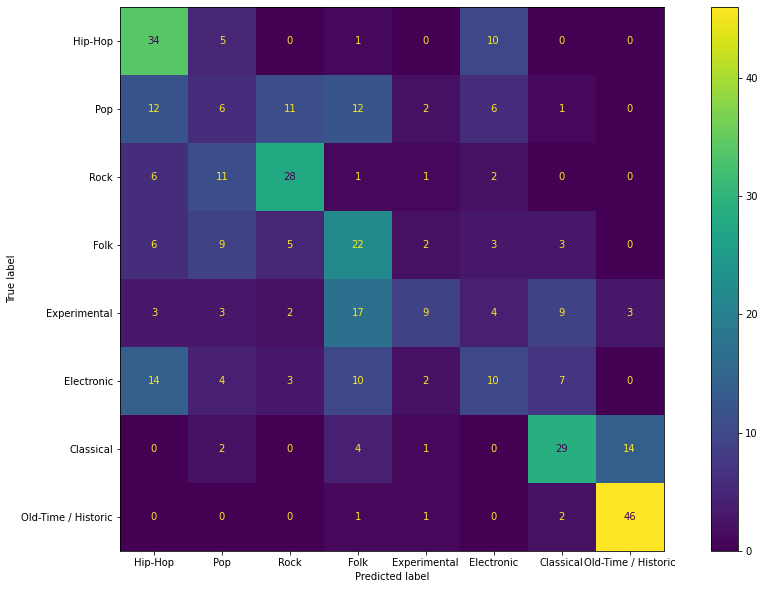

In [54]:
#Renaiming of predicted and true lables
y_pred = y_pred_song
y_true = np.array(test_song_labels)

#Calculating and printing confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=chosen_genres)
disp.plot() 

print(classification_report(y_true, y_pred,
                            target_names=chosen_genres))

#### 1- b)KNN classification for common artist

                     precision    recall  f1-score   support

            Hip-Hop       0.49      0.74      0.59        50
                Pop       0.27      0.20      0.23        50
               Rock       0.59      0.54      0.56        50
               Folk       0.47      0.54      0.50        50
       Experimental       0.41      0.28      0.33        50
         Electronic       0.47      0.38      0.42        50
          Classical       0.69      0.82      0.75        50
Old-Time / Historic       0.90      0.92      0.91        50

           accuracy                           0.55       400
          macro avg       0.54      0.55      0.54       400
       weighted avg       0.54      0.55      0.54       400



<Figure size 1224x720 with 0 Axes>

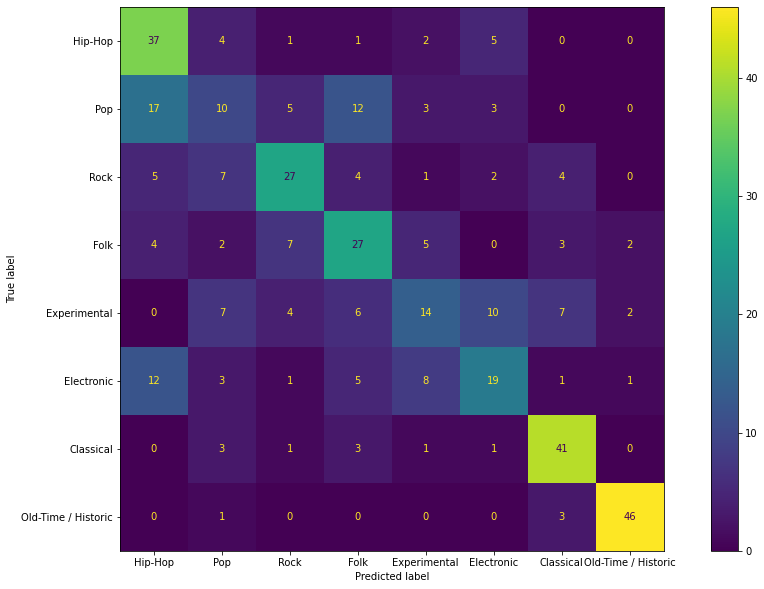

In [70]:
knn_clf_rand = KNeighborsClassifier(n_neighbors=1)
knn_clf_rand.fit(X_train_rand,y_train_rand)
knn_pred_rand = knn_clf_rand.predict(X_test_rand)
y_pred_song_rand = fext.majority_vote(knn_pred_rand, test_genre_song_length_list_rand)
#Renaiming of predicted and true lables
y_pred = y_pred_song_rand
y_true = np.array(test_song_labels_rand)

#Calculating and printing confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=chosen_genres)
disp.plot() 

print(classification_report(y_true, y_pred,
                            target_names=chosen_genres))

Here we can see that how much it affects to include common artists between different datasets of a genre.

### 2-Classification with SVC

Now it is time for SVC classification. In order to achieve the best performance, we are going to use Gaussian Kernel to represent complex dataset features. We start with no common artist distribution.

#### 2-a) SVC classification for no common artist 

In [56]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC()

In [57]:
svm_pred = svclassifier.predict(X_test)

In [58]:
y_pred_song = fext.majority_vote(svm_pred, test_genre_song_length_list)

                     precision    recall  f1-score   support

            Hip-Hop       0.45      0.70      0.55        50
                Pop       0.33      0.04      0.07        50
               Rock       0.56      0.69      0.62        49
               Folk       0.37      0.58      0.45        50
       Experimental       0.67      0.16      0.26        50
         Electronic       0.32      0.24      0.28        50
          Classical       0.51      0.64      0.57        50
Old-Time / Historic       0.73      0.94      0.82        50

           accuracy                           0.50       399
          macro avg       0.49      0.50      0.45       399
       weighted avg       0.49      0.50      0.45       399



<Figure size 1224x720 with 0 Axes>

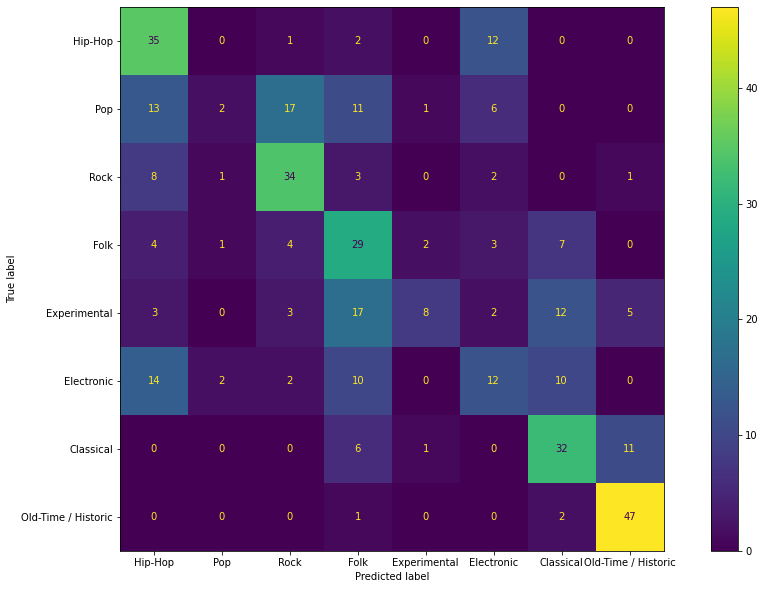

In [59]:
#Renaiming of predicted and true lables
y_pred = y_pred_song
y_true = np.array(test_song_labels)

#Calculating and printing confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=chosen_genres)
disp.plot() 

print(classification_report(y_true, y_pred,
                            target_names=chosen_genres))

#### 2-b) SVC classification for common artist 

In [60]:
svclassifier_rand = SVC(kernel='rbf')
svclassifier_rand.fit(X_train_rand, y_train_rand)


SVC()

                     precision    recall  f1-score   support

            Hip-Hop       0.52      0.78      0.62        50
                Pop       0.25      0.02      0.04        50
               Rock       0.53      0.64      0.58        50
               Folk       0.42      0.62      0.50        50
       Experimental       0.45      0.26      0.33        50
         Electronic       0.44      0.36      0.40        50
          Classical       0.57      0.78      0.66        50
Old-Time / Historic       0.86      0.86      0.86        50

           accuracy                           0.54       400
          macro avg       0.51      0.54      0.50       400
       weighted avg       0.51      0.54      0.50       400



<Figure size 1224x720 with 0 Axes>

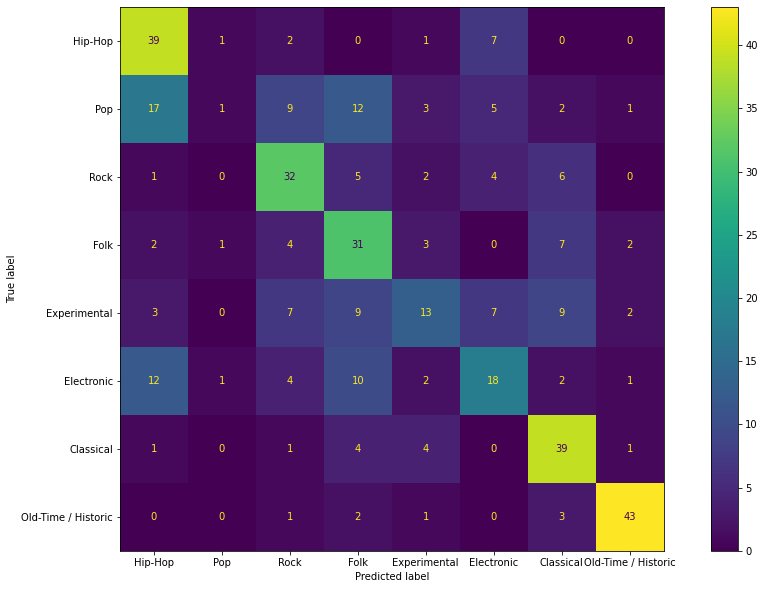

In [71]:
svm_pred_rand = svclassifier_rand.predict(X_test_rand)
y_pred_song_rand = fext.majority_vote(svm_pred_rand, test_genre_song_length_list_rand)

#Renaiming of predicted and true lables
y_pred = y_pred_song_rand
y_true = np.array(test_song_labels_rand)

#Calculating and printing confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=chosen_genres)
disp.plot() 

print(classification_report(y_true, y_pred,
                            target_names=chosen_genres))


### 3- Classification with Gaussian Naive Bayes

Now we will go with Gaussian Naive Bayes Approach. Since we don't use any hyperparameter here, we are directly running over our features.

#### 3-a) Gaussian Naive Bayes Classification for no common artists

In [62]:
gauss_clf = GaussianNB()
gauss_clf.fit(X_train, y_train)

GaussianNB()

In [63]:
gauss_pred = gauss_clf.predict(X_test)

In [64]:
y_pred_song = fext.majority_vote(gauss_pred, test_genre_song_length_list)

                     precision    recall  f1-score   support

            Hip-Hop       0.50      0.88      0.64        50
                Pop       0.00      0.00      0.00        50
               Rock       0.43      0.76      0.55        49
               Folk       0.54      0.60      0.57        50
       Experimental       0.75      0.12      0.21        50
         Electronic       0.26      0.10      0.14        50
          Classical       0.48      0.86      0.61        50
Old-Time / Historic       0.96      0.94      0.95        50

           accuracy                           0.53       399
          macro avg       0.49      0.53      0.46       399
       weighted avg       0.49      0.53      0.46       399



<Figure size 1224x720 with 0 Axes>

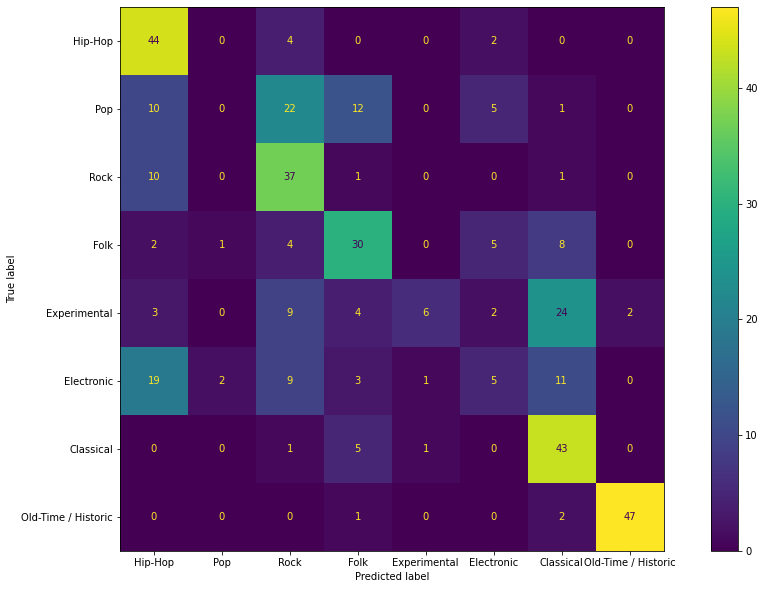

In [65]:
#Renaiming of predicted and true lables
y_pred = y_pred_song
y_true = np.array(test_song_labels)

#Calculating and printing confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=chosen_genres)
disp.plot() 

print(classification_report(y_true, y_pred,
                            target_names=chosen_genres))

#### 3-b) Gaussian Naive Bayes Classification for common artists

                     precision    recall  f1-score   support

            Hip-Hop       0.53      0.84      0.65        50
                Pop       0.50      0.04      0.07        50
               Rock       0.31      0.66      0.42        50
               Folk       0.45      0.38      0.41        50
       Experimental       0.55      0.12      0.20        50
         Electronic       0.39      0.14      0.21        50
          Classical       0.49      0.86      0.63        50
Old-Time / Historic       0.88      0.88      0.88        50

           accuracy                           0.49       400
          macro avg       0.51      0.49      0.43       400
       weighted avg       0.51      0.49      0.43       400



<Figure size 1224x720 with 0 Axes>

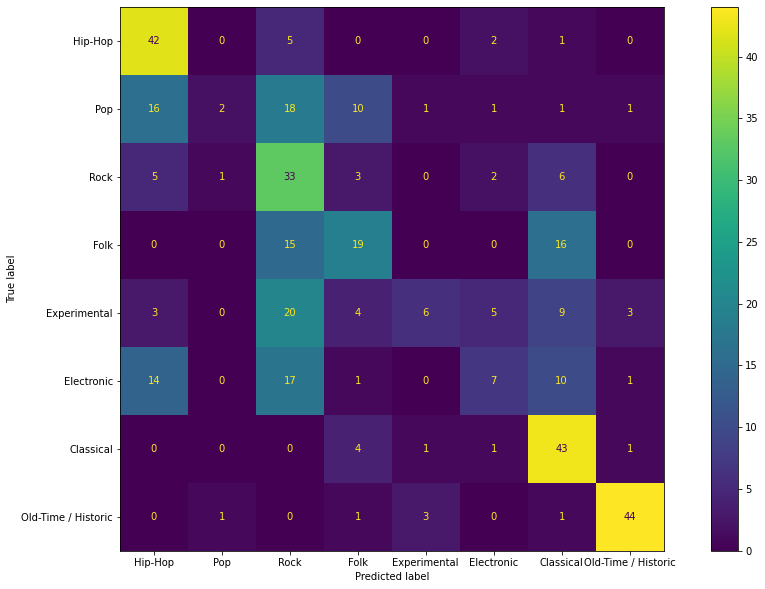

In [72]:
gauss_clf_rand = GaussianNB()
gauss_clf_rand.fit(X_train_rand, y_train_rand)
gauss_pred_rand = gauss_clf_rand.predict(X_test_rand)
y_pred_song_rand = fext.majority_vote(gauss_pred_rand, test_genre_song_length_list_rand)
#Renaiming of predicted and true lables
y_pred = y_pred_song_rand
y_true = np.array(test_song_labels_rand)

#Calculating and printing confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=chosen_genres)
disp.plot() 

print(classification_report(y_true, y_pred,
                            target_names=chosen_genres))

### 4- Classification with Multi-layer Perceptron

Now we with our latest classifier which is called multi-layer perceptron. Here we have some hyperparameters that we can optimize such as hidden layer sizes and learning rate initialization. We will try to find the optimal values on our validation dataset.

In [68]:
hl_sizes = [50, 100, 250, 500]
lr_inits = [0.0001, 0.001, 0.01, 0.1]
f_scores = []

for hl_size in hl_sizes:
    for lr_init in lr_inits:
        mlp_clf = MLPClassifier(hidden_layer_sizes=(hl_size),random_state=1, max_iter=800, learning_rate_init = lr_init)
        mlp_clf.fit(X_train, y_train)
        mlp_pred = mlp_clf.predict(X_valid)
        y_pred_song = fext.majority_vote(mlp_pred, valid_genre_song_length_list)
        y_pred = y_pred_song
        y_true = np.array(valid_song_labels)
        precision,recall,fscore,support=score(y_true,y_pred,average='macro')
        print("Macro avg fscore for hl_size = "+ str(hl_size) + " and for lr_init = " +str(lr_init) + " is " + str(fscore))
        f_scores.append(fscore)

Macro avg fscore for hl_size = 50 and for lr_init = 0.0001 is 0.45489847986947474
Macro avg fscore for hl_size = 50 and for lr_init = 0.001 is 0.48910456787090173


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro avg fscore for hl_size = 50 and for lr_init = 0.01 is 0.31719122375381403


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro avg fscore for hl_size = 50 and for lr_init = 0.1 is 0.027777777777777776
Macro avg fscore for hl_size = 100 and for lr_init = 0.0001 is 0.38634518434443643
Macro avg fscore for hl_size = 100 and for lr_init = 0.001 is 0.46837613002703293


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro avg fscore for hl_size = 100 and for lr_init = 0.01 is 0.3143199043967272


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro avg fscore for hl_size = 100 and for lr_init = 0.1 is 0.027777777777777776


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro avg fscore for hl_size = 250 and for lr_init = 0.0001 is 0.4416739783222471
Macro avg fscore for hl_size = 250 and for lr_init = 0.001 is 0.49760905728401084


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro avg fscore for hl_size = 250 and for lr_init = 0.01 is 0.33571899591636434


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro avg fscore for hl_size = 250 and for lr_init = 0.1 is 0.027777777777777776
Macro avg fscore for hl_size = 500 and for lr_init = 0.0001 is 0.4116170500761106


C:\Users\arday\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Macro avg fscore for hl_size = 500 and for lr_init = 0.001 is 0.5086197660285754


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro avg fscore for hl_size = 500 and for lr_init = 0.01 is 0.24505577036649423
Macro avg fscore for hl_size = 500 and for lr_init = 0.1 is 0.027777777777777776


C:\Users\arday\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From results, in order to be also time efficient we are going to choose hl_size = 50 and lr_init = 0.001 for our optimal training. 

#### 4-a) MLP Classification for no common artists

In [73]:
mlp_clf = MLPClassifier(hidden_layer_sizes = (50) ,random_state=1, max_iter=800, learning_rate_init = 0.001)
mlp_clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=50, max_iter=800, random_state=1)

In [74]:
mlp_pred = mlp_clf.predict(X_test)

In [87]:
y_pred_song = fext.majority_vote(mlp_pred, test_genre_song_length_list)

                     precision    recall  f1-score   support

            Hip-Hop       0.50      0.80      0.62        50
                Pop       0.19      0.14      0.16        50
               Rock       0.71      0.73      0.72        49
               Folk       0.50      0.70      0.58        50
       Experimental       0.62      0.40      0.49        50
         Electronic       0.36      0.08      0.13        50
          Classical       0.63      0.86      0.73        50
Old-Time / Historic       0.96      0.98      0.97        50

           accuracy                           0.59       399
          macro avg       0.56      0.59      0.55       399
       weighted avg       0.56      0.59      0.55       399



<Figure size 1224x720 with 0 Axes>

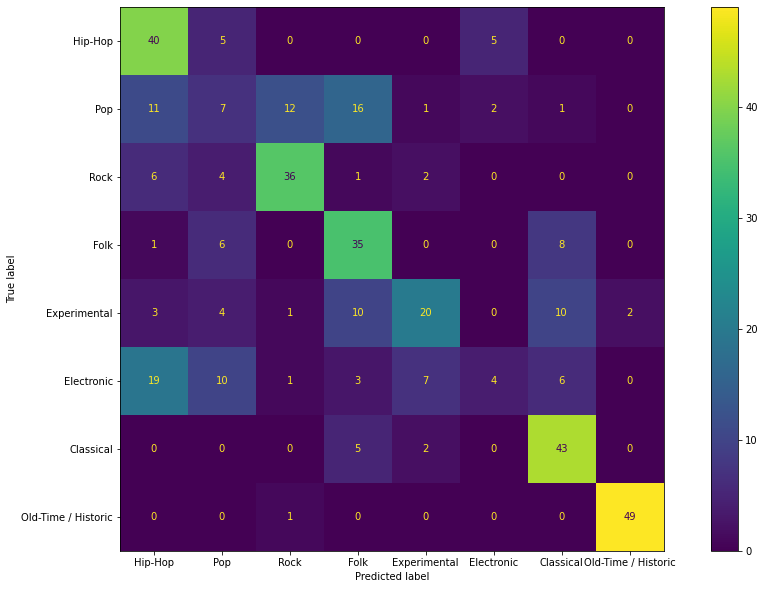

In [88]:
#Renaiming of predicted and true lables
y_pred = y_pred_song
y_true = np.array(test_song_labels)

#Calculating and printing confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=chosen_genres)
disp.plot() 

print(classification_report(y_true, y_pred,
                            target_names=chosen_genres))

#### 4-b) MLP Classification for common artists

In [77]:
mlp_clf_rand = MLPClassifier(hidden_layer_sizes=(50),random_state=1, max_iter=800, learning_rate_init = 0.001)
mlp_clf_rand.fit(X_train_rand, y_train_rand)
mlp_pred_rand = mlp_clf_rand.predict(X_test)


IndexError: index 0 is out of bounds for axis 0 with size 0

400
                     precision    recall  f1-score   support

            Hip-Hop       0.58      0.76      0.66        50
                Pop       0.56      0.20      0.29        50
               Rock       0.70      0.66      0.68        50
               Folk       0.60      0.62      0.61        50
       Experimental       0.66      0.62      0.64        50
         Electronic       0.42      0.54      0.47        50
          Classical       0.80      0.86      0.83        50
Old-Time / Historic       0.94      0.98      0.96        50

           accuracy                           0.66       400
          macro avg       0.66      0.66      0.64       400
       weighted avg       0.66      0.66      0.64       400



<Figure size 1224x720 with 0 Axes>

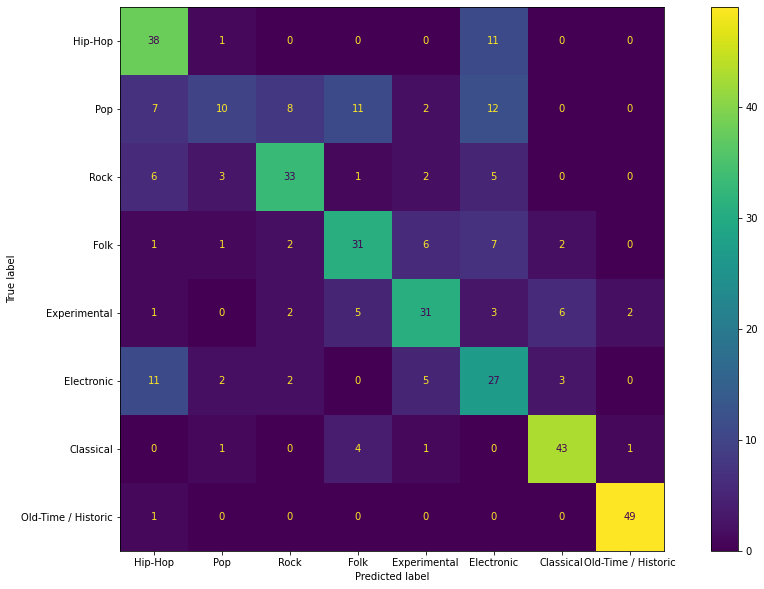

In [117]:
y_pred_song_rand = majority_vote(mlp_pred_rand, test_genre_song_length_list_rand)
#Renaiming of predicted and true lables
y_pred = y_pred_song_rand
y_true = np.array(test_song_labels_rand)

#Calculating and printing confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=chosen_genres)
disp.plot() 

print(classification_report(y_true, y_pred,
                            target_names=chosen_genres))